In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet'

In [3]:
df_trafic = pd.read_parquet(link)

In [4]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

In [5]:
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])

In [6]:
df_trafic['heure_arrondie'] = pd.to_datetime(df_trafic['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')
df_train = df_trafic[df_trafic['heure_arrondie'] < cutoff_date].copy()
df_train = df_train.sort_values(by=['nom_du_troncon', 'heure_arrondie'])

In [7]:
df_train['is_congested'] = df_train['etat_du_trafic'].apply(lambda x : 0 if x == 'Fluide' else 1)

In [8]:
df_test = pd.merge(
    df_prediction_taux_occupation,
    df_trafic,
    on=['heure_arrondie', 'nom_du_troncon']
)
df_test = df_test.drop(columns='taux_occupation')
df_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)
df_test = df_test.sort_values(by=['nom_du_troncon', 'heure_arrondie'])
df_test['is_congested'] = df_test['etat_du_trafic'].apply(lambda x : 0 if x == 'Fluide' else 1)

In [9]:
# --- ÉTAPE 1 : PRÉPARATION DES DONNÉES ---

# 1a. Sélection des features et de la cible
features = ['taux_occupation', 'weekday', 'is_vacances', 'is_ferie', 
            'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 
            'precipitation', 'visibility', 'wind_speed_10m']
target = 'is_congested'

# 1b. Encodage de la cible textuelle en numérique
# 'Fluide' -> 0, 'Dense' -> 1, 'Saturé' -> 2, 'Bloqué' -> 3
# label_encoder = LabelEncoder()
# df_train['target_enc'] = label_encoder.fit_transform(df_train[target])
# df_test['target_enc'] = label_encoder.transform(df_test[target]) # Utiliser le même encodeur
N_CLASSES = 2

# # Concaténer les features et la cible encodée pour la création des séquences
# data_train_processed = pd.concat([df_train[features], df_train['target_enc']], axis=1)
# data_test_processed = pd.concat([df_test[features], df_test['target_enc']], axis=1)

# 1c. Mise à l'échelle (Scaling) des features
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(df_train[features])
data_test_scaled = scaler.transform(df_test[features])

# 1d. Création des séquences
def create_classification_sequences(data, n_timesteps, n_classes):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:(i + n_timesteps), :-1]) # Toutes les features, sauf la dernière colonne (cible)
        y_index = int(data[i + n_timesteps, -1]) # La cible est la dernière colonne
        y.append(y_index)
    # One-hot encoding de la cible
    return np.array(X), to_categorical(y, num_classes=n_classes)

N_TIMESTEPS = 4 # 1h d'historique (4 * 15min)
X_train, y_train = create_classification_sequences(data_train_scaled, N_TIMESTEPS, N_CLASSES)
X_test, y_test = create_classification_sequences(data_test_scaled, N_TIMESTEPS, N_CLASSES)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}") # La dernière dimension est le nombre de classes

Shape de X_train: (1377407, 4, 9)
Shape de y_train: (1377407, 2)


In [10]:
# --- ÉTAPE 2 : CONSTRUCTION DU MODÈLE LSTM POUR LA CLASSIFICATION ---
N_FEATURES = X_train.shape[2]

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(N_TIMESTEPS, N_FEATURES)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# MODIFICATION : Couche de sortie avec 4 neurones (1 par classe) et activation softmax
model.add(Dense(units=N_CLASSES, activation='softmax'))

# MODIFICATION : Compilation avec une 'loss' adaptée à la classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,302 (126.18 KB)

 Trainable params: 32,302 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
y_train_integers = np.argmax(y_train, axis=1)

# Calculer les poids pour chaque classe (0 et 1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weights = dict(zip(np.unique(y_train_integers), weights))

print(f"Poids calculés pour les classes : {class_weights}")


Poids calculés pour les classes : {0: 1.0}


In [12]:
# --- ÉTAPE 3 : ENTRAÎNEMENT DU MODÈLE ---
print("\nDébut de l'entraînement...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, class_weight=class_weights )


Début de l'entraînement...
Epoch 1/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 155s 4ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 157s 4ms/step - accuracy: 1.0000 - loss: 2.9512e-12 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 163s 4ms/step - accuracy: 1.0000 - loss: 2.1893e-12 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 152s 4ms/step - accuracy: 1.0000 - loss: 3.3759e-13 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - accuracy: 1.0000 - loss: 2.7644e-14 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step - accuracy: 1.0000 - loss: 5.9159e-14 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 164s 4ms/step - accuracy: 1.0000 - loss: 1.8133e-13 - val_accuracy: 1.0000 - val


Évaluation sur le jeu de test...
13482/13482 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
--- Rapport de Classification ---
              precision    recall  f1-score   support

      Fluide       1.00      1.00      1.00    431420
  Non_fluide       0.00      0.00      0.00         0

    accuracy                           1.00    431420
   macro avg       0.50      0.50      0.50    431420
weighted avg       1.00      1.00      1.00    431420


--- Matrice de Confusion ---


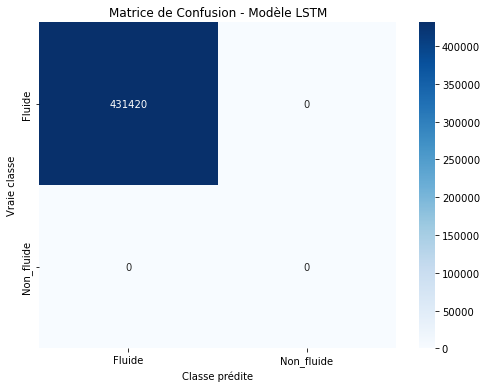

In [14]:

# --- ÉTAPE 4 : PRÉDICTION ET ÉVALUATION ---
print("\nÉvaluation sur le jeu de test...")
# La prédiction donne des probabilités pour chaque classe
predictions_proba = model.predict(X_test)

# Pour obtenir la classe prédite, on prend l'index de la probabilité la plus élevée
y_pred_classes = np.argmax(predictions_proba, axis=1)

# On doit aussi récupérer les vraies classes (non one-hot-encodées) pour la comparaison
y_true_classes = np.argmax(y_test, axis=1)

# Afficher le rapport de classification
target_names = ['Fluide','Non_fluide']

# La liste des index numériques correspondants
# ex: [0, 1, 2, 3]
labels_numeriques = range(N_CLASSES) 

# Afficher le rapport de classification en forçant tous les labels
print("--- Rapport de Classification ---")
# J'ajoute 'zero_division=0' pour éviter un avertissement si une classe n'a aucun vrai échantillon
print(classification_report(y_true_classes, y_pred_classes, 
                            labels=labels_numeriques, 
                            target_names=target_names, 
                            zero_division=0))

# Afficher la matrice de confusion en forçant tous les labels
print("\n--- Matrice de Confusion ---")
# Cela garantit que la matrice cm sera toujours de taille 4x4
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_numeriques)

plt.figure(figsize=(8, 6))
# Le code d'affichage est bon car il utilise déjà target_names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Modèle LSTM')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()